# Artificial Neural Network

## Implementation

### Imports

In [1]:
%matplotlib inline
import scipy.special
import matplotlib.pyplot as plt
import numpy
import pandas
import random

### Global variables

In [2]:
input_nodes = 784
hidden_nodes = 400
output_nodes = 10

# initial values
learning_rate = 0.2
batch_size = 40
epochs = 100

### Neural network class

In [3]:
class neuralNetwork:
	"""Artificial Neural Network classifier.

	Parameters
	------------
	lr : float
		Learning rate (between 0.0 and 1.0)
	ep : int
		Number of epochs for training the network towards achieving convergence
	batch_size : int
		Size of the training batch to be used when calculating the gradient descent.
		batch_size = 0 standard gradient descent
		batch_size > 0 stochastic gradient descent

	inodes : int
		Number of input nodes which is normally the number of features in an instance.
	hnodes : int
		Number of hidden nodes in the net.
	onodes : int
		Number of output nodes in the net.


	Attributes
	-----------
	wih : 2d-array
		Input2Hidden node weights after fitting
	who : 2d-array
		Hidden2Output node weights after fitting
	E : list
		Sum-of-squares error value in each epoch.

	Results : list
		Target and predicted class labels for the test data.

	Functions
	---------
	activation_function : float (between 1 and -1)
		implments the sigmoid function which squashes the node input
	"""

	def __init__(self, inputnodes = 784, hiddennodes = 200, outputnodes = 10, learningrate = 0.2, batch_size = 40, epochs = 100):
		self.inodes = inputnodes
		self.hnodes = hiddennodes
		self.onodes = outputnodes

		#link weight matrices, wih (input to hidden) and who (hidden to output)
		#a weight on link from node i to node j is w_ij

		#Draw random samples from a normal (Gaussian) distribution centered around 0.
		#numpy.random.normal(loc to centre gaussian=0.0, scale=1, size=dimensions of the array we want)
		#scale is usually set to the standard deviation which is related to the number of incoming links i.e.
		#1/sqrt(num of incoming inputs). we use pow to raise it to the power of -0.5.
		#We have set 0 as the centre of the guassian dist.
		# size is set to the dimensions of the number of hnodes, inodes and onodes
		self.wih = numpy.random.normal(0.0, pow(self.inodes, -0.5), (self.hnodes, self.inodes))
		self.who = numpy.random.normal(0.0, pow(self.onodes, -0.5), (self.onodes, self.hnodes))

		#set the learning rate
		self.lr = learningrate

		#set the batch size
		self.bs = batch_size

		#set the number of epochs
		self.ep = epochs

		#store errors at each epoch
		self.E = []

		#store results from testing the model
		#keep track of the network performance on each test instance
		self.results = []

		#define the activation function here
		#specify the sigmoid squashing function. Here expit() provides the sigmoid function.
		#lambda is a short cut function which is executed there and then with no def (i.e. like an anonymous function)
		self.activation_function = lambda x: scipy.special.expit(x)

		pass

	def batch_input(self, input_list):
		"""Yield consecutive batches of the specified size from the input list."""
		for i in range(0, len(input_list), self.bs):
			yield input_list[i:i + self.bs]

	#train the neural net
	#note the first part is very similar to the query function because they both require the forward pass
	def train(self, train_inputs):
		"""Training the neural net.
			This includes the forward pass ; error computation;
			backprop of the error ; calculation of gradients and updating the weights.

			Parameters
			----------
			train_inputs : {array-like}, shape = [n_instances, n_features]
			Training vectors, where n_instances is the number of training instances and
			n_features is the number of features.
			Note this contains all features including the class feature which is in first position

			Returns
			-------
			self : object
		"""

		for e in range(self.ep):
			print("Training epoch#: ", e)
			sum_error = 0.0
			for batch in self.batch_input(train_inputs):
				#creating variables to store the gradients
				delta_who = 0
				delta_wih = 0

				# iterate through the inputs sent in
				for instance in batch:
					# split it by the commas
					all_values = instance.split(',')
					# scale and shift the inputs to address the problem of diminishing weights due to multiplying by zero
					# divide the raw inputs which are in the range 0-255 by 255 will bring them into the range 0-1
					# multiply by 0.99 to bring them into the range 0.0 - 0.99.
					# add 0.01 to shift them up to the desired range 0.01 - 1.
					inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
					#create the target output values for each instance so that we can use it with the neural net
					#note we need 10 nodes where each represents one of the digits
					targets = numpy.zeros(output_nodes) + 0.01 #all initialised to 0.01
					#all_value[0] has the target class label for this instance
					targets[int(all_values[0])] = 0.99

					#convert  inputs list to 2d array
					inputs = numpy.array(inputs,  ndmin = 2).T
					targets = numpy.array(targets, ndmin = 2).T

					#calculate signals into hidden layer
					hidden_inputs = numpy.dot(self.wih, inputs)
					#calculate the signals emerging from the hidden layer
					hidden_outputs = self.activation_function(hidden_inputs)

					#calculate signals into final output layer
					final_inputs = numpy.dot(self.who, hidden_outputs)
					#calculate the signals emerging from final output layer
					final_outputs = self.activation_function(final_inputs)

					#to calculate the error we need to compute the element wise diff between target and actual
					output_errors = targets - final_outputs
					#Next distribute the error to the hidden layer such that hidden layer error
					#is the output_errors, split by weights, recombined at hidden nodes
					hidden_errors = numpy.dot(self.who.T, output_errors)

					## for each instance accumilate the gradients from each instance
					## delta_who are the gradients between hidden and output weights
					## delta_wih are the gradients between input and hidden weights
					delta_who += numpy.dot((output_errors * final_outputs * (1.0 - final_outputs)), numpy.transpose(hidden_outputs))
					delta_wih += numpy.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), numpy.transpose(inputs))

					sum_error += numpy.dot(output_errors.T, output_errors)#this is the sum of squared error accumilated over each batced instance

				pass #instance

				# update the weights by multiplying the gradient with the learning rate
				# note that the deltas are divided by batch size to obtain the average gradient according to the given batch
				# obviously if batch size = 1 then we dont need to bother with an average
				self.who += self.lr * (delta_who / self.bs)
				self.wih += self.lr * (delta_wih / self.bs)
			pass # batch
			self.E.append(numpy.asfarray(sum_error).flatten())
			print("errors (SSE): ", self.E[-1])
		pass # epoch

	#query the neural net
	def query(self, inputs_list):
		#convert inputs_list to a 2d array
		#print(numpy.matrix(inputs_list))
		#inputs_list [[ 1.   0.5 -1.5]]
		inputs = numpy.array(inputs_list, ndmin = 2).T
		#once converted it appears as follows
		#[[ 1. ]
		# [ 0.5]
		# [-1.5]]
		#print(numpy.matrix(inputs))

		#propogate input into hidden layer. This is the start of the forward pass
		hidden_inputs = numpy.dot(self.wih, inputs)

		#squash the content in the hidden node using the sigmoid function (value between 1, -1)
		hidden_outputs = self.activation_function(hidden_inputs)

		#propagate into output layer and the apply the squashing sigmoid function
		final_inputs = numpy.dot(self.who, hidden_outputs)

		final_outputs = self.activation_function(final_inputs)
		return final_outputs

	#iterate through all the test data to calculate model accuracy
	def test(self, test_inputs):
		self.results = []

		#go through each test instances
		for instance in test_inputs:
			all_values = instance.split(',') # extract the input feature values for the instance

			target_label = int(all_values[0]) # get the target class for the instance

			#scale and shift the inputs this is to make sure values dont lead to zero when multiplied with weights
			inputs = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01

			#query the network with test inputs
			#note this returns 10 output values ; of which the index of the highest value
			# is the networks predicted class label
			outputs = self.query(inputs)

			#get the index of the highest output node as this corresponds to the predicted class
			predict_label = numpy.argmax(outputs) #this is the class predicted by the ANN

			self.results.append([predict_label, target_label])
			#compute network error
			#if (predict_label == target_label):
			#	self.results.append(1)
			#else:
			#	self.results.append(0)
			pass
		pass
		self.results = numpy.asfarray(self.results) # flatten results to avoid nested arrays

## MNIST dataset

### Loading files

In [8]:
mnist_train_file = open("../datasets/mnist_train.csv", 'r')
mnist_train_list = mnist_train_file.readlines() 
mnist_train_file.close() 
print("train set size: ", len(mnist_train_list))

mnist_test_file = open("../datasets/mnist_test.csv", 'r')
mnist_test_list = mnist_test_file.readlines()
mnist_test_file.close()
print("test set size: ", len(mnist_test_list))

# quick run
#mnist_train_list = numpy.random.choice(mnist_train_list, 1000, replace = False)
#mnist_test_list = numpy.random.choice(mnist_test_list, 1000, replace = False)

train set size:  60000
test set size:  10000


### Normalization

In [9]:
print(mnist_train_list[0])
for entry in mnist_train_list:
    for pixel in entry:
        pixel /= 255
print(mnist_train_list[0])

5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,18,18,18,126,136,175,26,166,255,247,127,0,0,0,0,0,0,0,0,0,0,0,0,30,36,94,154,170,253,253,253,253,253,225,172,253,242,195,64,0,0,0,0,0,0,0,0,0,0,0,49,238,253,253,253,253,253,253,253,253,251,93,82,82,56,39,0,0,0,0,0,0,0,0,0,0,0,0,18,219,253,253,253,253,253,198,182,247,241,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,80,156,107,253,253,205,11,0,43,154,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,14,1,154,253,90,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,139,253,190,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,190,253,70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,35,241,225,160,108,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,81,240,253,253,119,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

TypeError: unsupported operand type(s) for /=: 'str' and 'int'

#### Epochs

##### Training

In [5]:
ann_epoch_numbers_list = []
epoch_numbers = [1, 10, 100, 200, 300]

for epoch_number in epoch_numbers:
    print("Number of epochs : ", epoch_number)
    n = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate, batch_size, epoch_number)
    n.train(mnist_train_list)
    ann_epoch_numbers_list.append(n)

Number of epochs :  1
Training epoch#:  0
errors (SSE):  [688.9232462]
Number of epochs :  10
Training epoch#:  0
errors (SSE):  [795.56803193]
Training epoch#:  1
errors (SSE):  [307.34538554]
Training epoch#:  2
errors (SSE):  [245.38153364]
Training epoch#:  3
errors (SSE):  [214.00881938]
Training epoch#:  4
errors (SSE):  [193.99647263]
Training epoch#:  5
errors (SSE):  [179.59215732]
Training epoch#:  6
errors (SSE):  [168.41552912]
Training epoch#:  7
errors (SSE):  [159.31073204]
Training epoch#:  8
errors (SSE):  [151.64285044]
Training epoch#:  9
errors (SSE):  [145.02702898]
Number of epochs :  100
Training epoch#:  0
errors (SSE):  [758.13877082]
Training epoch#:  1
errors (SSE):  [292.53420884]
Training epoch#:  2
errors (SSE):  [234.2113082]
Training epoch#:  3
errors (SSE):  [205.77270801]
Training epoch#:  4
errors (SSE):  [187.60357501]
Training epoch#:  5
errors (SSE):  [174.34016438]
Training epoch#:  6
errors (SSE):  [163.87270802]
Training epoch#:  7
errors (SSE):

errors (SSE):  [56.27774279]
Training epoch#:  52
errors (SSE):  [55.4506281]
Training epoch#:  53
errors (SSE):  [54.64277164]
Training epoch#:  54
errors (SSE):  [53.85314688]
Training epoch#:  55
errors (SSE):  [53.080819]
Training epoch#:  56
errors (SSE):  [52.32494238]
Training epoch#:  57
errors (SSE):  [51.58475394]
Training epoch#:  58
errors (SSE):  [50.85956368]
Training epoch#:  59
errors (SSE):  [50.14874389]
Training epoch#:  60
errors (SSE):  [49.45171855]
Training epoch#:  61
errors (SSE):  [48.76795396]
Training epoch#:  62
errors (SSE):  [48.09695123]
Training epoch#:  63
errors (SSE):  [47.43824096]
Training epoch#:  64
errors (SSE):  [46.79137995]
Training epoch#:  65
errors (SSE):  [46.15594969]
Training epoch#:  66
errors (SSE):  [45.5315562]
Training epoch#:  67
errors (SSE):  [44.91783106]
Training epoch#:  68
errors (SSE):  [44.31443307]
Training epoch#:  69
errors (SSE):  [43.72105052]
Training epoch#:  70
errors (SSE):  [43.13740347]
Training epoch#:  71
erro

errors (SSE):  [120.29971444]
Training epoch#:  14
errors (SSE):  [116.32390864]
Training epoch#:  15
errors (SSE):  [112.62665737]
Training epoch#:  16
errors (SSE):  [109.1714737]
Training epoch#:  17
errors (SSE):  [105.93029813]
Training epoch#:  18
errors (SSE):  [102.88208478]
Training epoch#:  19
errors (SSE):  [100.01126328]
Training epoch#:  20
errors (SSE):  [97.3058116]
Training epoch#:  21
errors (SSE):  [94.75530221]
Training epoch#:  22
errors (SSE):  [92.34953758]
Training epoch#:  23
errors (SSE):  [90.07804615]
Training epoch#:  24
errors (SSE):  [87.93022936]
Training epoch#:  25
errors (SSE):  [85.89576097]
Training epoch#:  26
errors (SSE):  [83.96493538]
Training epoch#:  27
errors (SSE):  [82.12884578]
Training epoch#:  28
errors (SSE):  [80.37941085]
Training epoch#:  29
errors (SSE):  [78.70932166]
Training epoch#:  30
errors (SSE):  [77.11197046]
Training epoch#:  31
errors (SSE):  [75.5813894]
Training epoch#:  32
errors (SSE):  [74.11220151]
Training epoch#: 

errors (SSE):  [12.33922084]
Training epoch#:  177
errors (SSE):  [12.22784724]
Training epoch#:  178
errors (SSE):  [12.11790075]
Training epoch#:  179
errors (SSE):  [12.00935939]
Training epoch#:  180
errors (SSE):  [11.9022016]
Training epoch#:  181
errors (SSE):  [11.79640624]
Training epoch#:  182
errors (SSE):  [11.69195259]
Training epoch#:  183
errors (SSE):  [11.58882031]
Training epoch#:  184
errors (SSE):  [11.48698948]
Training epoch#:  185
errors (SSE):  [11.38644054]
Training epoch#:  186
errors (SSE):  [11.28715433]
Training epoch#:  187
errors (SSE):  [11.18911202]
Training epoch#:  188
errors (SSE):  [11.09229515]
Training epoch#:  189
errors (SSE):  [10.99668562]
Training epoch#:  190
errors (SSE):  [10.90226564]
Training epoch#:  191
errors (SSE):  [10.80901775]
Training epoch#:  192
errors (SSE):  [10.71692482]
Training epoch#:  193
errors (SSE):  [10.62597002]
Training epoch#:  194
errors (SSE):  [10.53613682]
Training epoch#:  195
errors (SSE):  [10.44740898]
Tra

##### Compute the accuracy of the neural networks

In [13]:
epoch_numbers_model_results = []
for model in ann_epoch_numbers_list: 
    correct = 0
    model.test(mnist_test_list)
    for result in model.results:
        if (result[0] == result[1]):
                correct += 1
        pass
    correct = 100 * (correct/len(model.results))
    epoch_numbers_model_results.append(correct)
    pass
pass

##### Show the accuracy of the neural networks

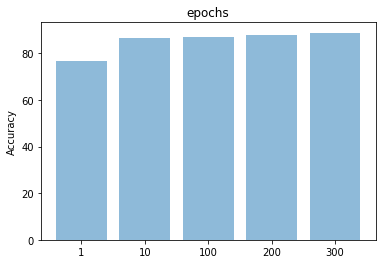

In [30]:
objects = epoch_numbers
y_pos = numpy.arange(len(objects))
performance = epoch_numbers_model_results

plt.bar(y_pos, performance, align = 'center', alpha = 0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('epochs')

fig_epoch_numbers = plt.gcf()
plt.show()
fig_epoch_numbers.savefig('../images/ann_epoch_numbers_mnist.png', dpi = 300)

#### Batch size

##### Training

In [27]:
ann_batch_sizes_list = []
batch_sizes = [1, 10, 100, 200, len(mnist_train_list)]

for batch_size in batch_sizes:
    print("Batch_sizes : ", batch_size)
    n = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate, batch_size, epochs)
    n.train(mnist_train_list)
    ann_batch_sizes_list.append(n)

Batch_sizes :  1
Training epoch#:  0
errors (SSE):  [567.57328644]
Training epoch#:  1
errors (SSE):  [269.85573668]
Training epoch#:  2
errors (SSE):  [190.40726136]
Training epoch#:  3
errors (SSE):  [126.40779472]
Training epoch#:  4
errors (SSE):  [77.46012475]
Training epoch#:  5
errors (SSE):  [55.96152622]
Training epoch#:  6
errors (SSE):  [35.14364815]
Training epoch#:  7
errors (SSE):  [17.84279538]
Training epoch#:  8
errors (SSE):  [11.45234666]
Training epoch#:  9
errors (SSE):  [6.50414226]
Training epoch#:  10
errors (SSE):  [3.77081579]
Training epoch#:  11
errors (SSE):  [2.92099592]
Training epoch#:  12
errors (SSE):  [2.22712959]
Training epoch#:  13
errors (SSE):  [1.71084948]
Training epoch#:  14
errors (SSE):  [1.42373953]
Training epoch#:  15
errors (SSE):  [1.27601358]
Training epoch#:  16
errors (SSE):  [1.10942377]
Training epoch#:  17
errors (SSE):  [0.98582873]
Training epoch#:  18
errors (SSE):  [0.90458442]
Training epoch#:  19
errors (SSE):  [0.83617271]


errors (SSE):  [0.8156231]
Training epoch#:  68
errors (SSE):  [0.79976988]
Training epoch#:  69
errors (SSE):  [0.78488836]
Training epoch#:  70
errors (SSE):  [0.77063317]
Training epoch#:  71
errors (SSE):  [0.75672121]
Training epoch#:  72
errors (SSE):  [0.74295361]
Training epoch#:  73
errors (SSE):  [0.72925004]
Training epoch#:  74
errors (SSE):  [0.71567914]
Training epoch#:  75
errors (SSE):  [0.70245048]
Training epoch#:  76
errors (SSE):  [0.68983209]
Training epoch#:  77
errors (SSE):  [0.67798897]
Training epoch#:  78
errors (SSE):  [0.66692541]
Training epoch#:  79
errors (SSE):  [0.65655389]
Training epoch#:  80
errors (SSE):  [0.64676988]
Training epoch#:  81
errors (SSE):  [0.63748701]
Training epoch#:  82
errors (SSE):  [0.62864377]
Training epoch#:  83
errors (SSE):  [0.62019846]
Training epoch#:  84
errors (SSE):  [0.61211663]
Training epoch#:  85
errors (SSE):  [0.60436021]
Training epoch#:  86
errors (SSE):  [0.59688586]
Training epoch#:  87
errors (SSE):  [0.589

errors (SSE):  [112.50381739]
Training epoch#:  32
errors (SSE):  [110.58405262]
Training epoch#:  33
errors (SSE):  [107.9121009]
Training epoch#:  34
errors (SSE):  [106.17649946]
Training epoch#:  35
errors (SSE):  [103.73971073]
Training epoch#:  36
errors (SSE):  [102.11532975]
Training epoch#:  37
errors (SSE):  [99.90474368]
Training epoch#:  38
errors (SSE):  [98.3616867]
Training epoch#:  39
errors (SSE):  [96.37714331]
Training epoch#:  40
errors (SSE):  [94.90180143]
Training epoch#:  41
errors (SSE):  [93.13199774]
Training epoch#:  42
errors (SSE):  [91.71495435]
Training epoch#:  43
errors (SSE):  [90.13394248]
Training epoch#:  44
errors (SSE):  [88.7717334]
Training epoch#:  45
errors (SSE):  [87.34357911]
Training epoch#:  46
errors (SSE):  [86.03890913]
Training epoch#:  47
errors (SSE):  [84.72646572]
Training epoch#:  48
errors (SSE):  [83.4831034]
Training epoch#:  49
errors (SSE):  [82.25709486]
Training epoch#:  50
errors (SSE):  [81.07517604]
Training epoch#:  5

errors (SSE):  [161.70532863]
Training epoch#:  94
errors (SSE):  [158.51623179]
Training epoch#:  95
errors (SSE):  [159.90545285]
Training epoch#:  96
errors (SSE):  [156.5454963]
Training epoch#:  97
errors (SSE):  [158.18590457]
Training epoch#:  98
errors (SSE):  [154.67327424]
Training epoch#:  99
errors (SSE):  [156.53679429]


##### Compute the accuracy of the neural networks

In [28]:
batch_sizes_model_results = []
for model in ann_batch_sizes_list: 
    correct = 0
    model.test(mnist_test_list)
    for result in model.results:
        if (result[0] == result[1]):
                correct += 1
        pass
    correct = 100 * (correct/len(model.results))
    batch_sizes_model_results.append(correct)
    pass
pass

##### Show the accuracy of the neural networks

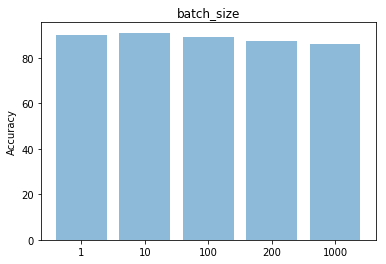

In [29]:
objects = batch_sizes
y_pos = numpy.arange(len(objects))
performance = batch_sizes_model_results

plt.bar(y_pos, performance, align = 'center', alpha = 0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('batch_size')

fig_batch_sizes = plt.gcf()
plt.show()
fig_batch_sizes.savefig('../images/ann_batch_sizes_mnist.png', dpi = 300)

#### Learning rate

##### Training

In [24]:
ann_learning_rates_list = []
learning_rates = [0.01, 0.1, 0.2, 0.4, 0.8]

for learning_rate in learning_rates:
    print("Learning_rates : ", learning_rate)
    n = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate, batch_size, epochs)
    n.train(mnist_train_list)
    ann_learning_rates_list.append(n)

Learning_rates :  0.01
Training epoch#:  0
errors (SSE):  [2604.90027511]
Training epoch#:  1
errors (SSE):  [1211.81768303]
Training epoch#:  2
errors (SSE):  [939.50484057]
Training epoch#:  3
errors (SSE):  [864.74277469]
Training epoch#:  4
errors (SSE):  [820.99068921]
Training epoch#:  5
errors (SSE):  [786.5484068]
Training epoch#:  6
errors (SSE):  [756.82903343]
Training epoch#:  7
errors (SSE):  [730.35018158]
Training epoch#:  8
errors (SSE):  [706.25156508]
Training epoch#:  9
errors (SSE):  [684.00035175]
Training epoch#:  10
errors (SSE):  [663.31996419]
Training epoch#:  11
errors (SSE):  [644.06805635]
Training epoch#:  12
errors (SSE):  [626.14824207]
Training epoch#:  13
errors (SSE):  [609.47255278]
Training epoch#:  14
errors (SSE):  [593.95178487]
Training epoch#:  15
errors (SSE):  [579.49595012]
Training epoch#:  16
errors (SSE):  [566.01696923]
Training epoch#:  17
errors (SSE):  [553.43102036]
Training epoch#:  18
errors (SSE):  [541.65999724]
Training epoch#: 

errors (SSE):  [153.15039387]
Training epoch#:  61
errors (SSE):  [152.22117496]
Training epoch#:  62
errors (SSE):  [151.31002671]
Training epoch#:  63
errors (SSE):  [150.41628398]
Training epoch#:  64
errors (SSE):  [149.53931575]
Training epoch#:  65
errors (SSE):  [148.67852276]
Training epoch#:  66
errors (SSE):  [147.83333545]
Training epoch#:  67
errors (SSE):  [147.003212]
Training epoch#:  68
errors (SSE):  [146.18763664]
Training epoch#:  69
errors (SSE):  [145.38611804]
Training epoch#:  70
errors (SSE):  [144.59818789]
Training epoch#:  71
errors (SSE):  [143.82339955]
Training epoch#:  72
errors (SSE):  [143.06132684]
Training epoch#:  73
errors (SSE):  [142.31156292]
Training epoch#:  74
errors (SSE):  [141.57371924]
Training epoch#:  75
errors (SSE):  [140.84742458]
Training epoch#:  76
errors (SSE):  [140.13232412]
Training epoch#:  77
errors (SSE):  [139.42807864]
Training epoch#:  78
errors (SSE):  [138.73436368]
Training epoch#:  79
errors (SSE):  [138.05086883]
Tra

errors (SSE):  [129.00034733]
Training epoch#:  22
errors (SSE):  [126.31594953]
Training epoch#:  23
errors (SSE):  [123.78456111]
Training epoch#:  24
errors (SSE):  [121.39030802]
Training epoch#:  25
errors (SSE):  [119.11980206]
Training epoch#:  26
errors (SSE):  [116.9616488]
Training epoch#:  27
errors (SSE):  [114.90605358]
Training epoch#:  28
errors (SSE):  [112.94450823]
Training epoch#:  29
errors (SSE):  [111.06954386]
Training epoch#:  30
errors (SSE):  [109.27453707]
Training epoch#:  31
errors (SSE):  [107.55355945]
Training epoch#:  32
errors (SSE):  [105.90126184]
Training epoch#:  33
errors (SSE):  [104.31278623]
Training epoch#:  34
errors (SSE):  [102.78369921]
Training epoch#:  35
errors (SSE):  [101.30994184]
Training epoch#:  36
errors (SSE):  [99.88779135]
Training epoch#:  37
errors (SSE):  [98.51383128]
Training epoch#:  38
errors (SSE):  [97.18492716]
Training epoch#:  39
errors (SSE):  [95.89820568]
Training epoch#:  40
errors (SSE):  [94.6510359]
Training

errors (SSE):  [43.1333055]
Training epoch#:  86
errors (SSE):  [42.55327477]
Training epoch#:  87
errors (SSE):  [41.98013139]
Training epoch#:  88
errors (SSE):  [41.41383441]
Training epoch#:  89
errors (SSE):  [40.85445282]
Training epoch#:  90
errors (SSE):  [40.30216469]
Training epoch#:  91
errors (SSE):  [39.75724701]
Training epoch#:  92
errors (SSE):  [39.22005456]
Training epoch#:  93
errors (SSE):  [38.69098833]
Training epoch#:  94
errors (SSE):  [38.17045715]
Training epoch#:  95
errors (SSE):  [37.65883834]
Training epoch#:  96
errors (SSE):  [37.15644367]
Training epoch#:  97
errors (SSE):  [36.66349567]
Training epoch#:  98
errors (SSE):  [36.1801165]
Training epoch#:  99
errors (SSE):  [35.70632899]


##### Compute the accuracy of the neural networks

In [25]:
learning_rates_model_results = []
for model in ann_learning_rates_list: 
    correct = 0
    model.test(mnist_test_list)
    for result in model.results:
        if (result[0] == result[1]):
                correct += 1
        pass
    correct = 100 * (correct/len(model.results))
    learning_rates_model_results.append(correct)
    pass
pass

##### Show the accuracy of the neural networks

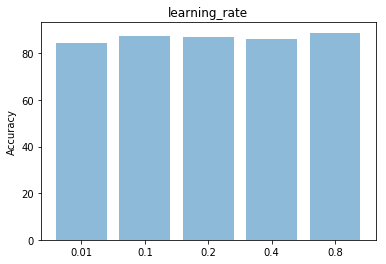

In [31]:
objects = learning_rates
y_pos = numpy.arange(len(objects))
performance = learning_rates_model_results

plt.bar(y_pos, performance, align = 'center', alpha = 0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Accuracy')
plt.title('learning_rate')

fig_learning_rates = plt.gcf()
plt.show()
fig_learning_rates.savefig('../images/ann_learning_rates_mnist.png', dpi = 300)

## "Red and White Wine Quality EDA" dataset

### Loading file

In [4]:
wine_quality_file = open("../datasets/winequality-white.csv", 'r')
wine_quality_list = wine_quality_file.readlines()
wine_quality_file.close()

print("set size: ", len(wine_quality_list))

set size:  4899


### Normalize data

In [5]:
print(wine_quality_list[1])
"""
for entry in wine_quality_list:
    entry = entry
"""
print(wine_quality_list[1])

7;0.27;0.36;20.7;0.045;45;170;1.001;3;0.45;8.8;6

7;0.27;0.36;20.7;0.045;45;170;1.001;3;0.45;8.8;6



### Split data into *training set* and *testing set*

In [6]:
random.shuffle(wine_quality_list)

wine_quality_train_list = wine_quality_list[:int(len(wine_quality_list) * .8)]
print("train set size: ", len(wine_quality_train_list))

wine_quality_test_list = wine_quality_list[int(len(wine_quality_list) * .8):] # why does it work ? should be 0.2 ! is there something I missed ? it's been 5 years I haven't used Python, mais quand même faut pas abuser...
print("test set size: ", len(wine_quality_test_list))

train set size:  3919
test set size:  980


#### Epochs

##### Training

In [8]:
ann_epoch_numbers_list = []
epoch_numbers = [1, 10, 100, 200, 300]

for epoch_number in epoch_numbers:
    print("Number of epochs : ", epoch_number)
    n = neuralNetwork(input_nodes = 11, hidden_nodes, output_nodes = 2, learning_rate, batch_size, epoch_number)
    n.train(wine_quality_train_list)
    ann_epoch_numbers_list.append(n)

Number of epochs :  1
Training epoch#:  0


ValueError: invalid literal for int() with base 10: '7.1;0.18;0.74;15.6;0.044;44;176;0.9996;3.38;0.67;9;6\n'

##### Compute the accuracy of the neural networks

In [8]:
epoch_numbers_model_results = []
for model in ann_epoch_numbers_list: 
    correct = 0
    model.test(mnist_test_list)
    for result in model.results:
        if (result[0] == result[1]):
                correct += 1
        pass
    correct = 100 * (correct/len(model.results))
    epoch_numbers_model_results.append(correct)
    pass
pass

Test set accuracy% =  89.8


##### Show the accuracy of the neural networks

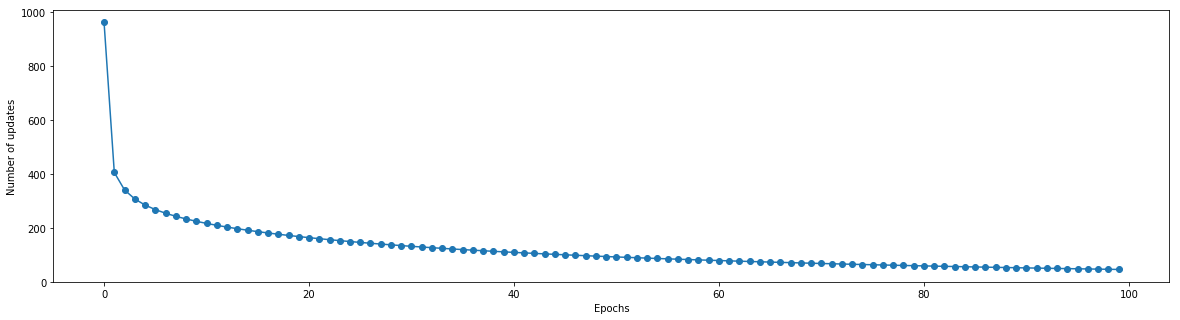

In [6]:
for ann in n_list:
    print("Number of epochs : ", ann.ep)
    plt.figure(figsize = (20,5))
    plt.plot(range(0, ann.ep), numpy.asfarray(ann.E), marker = 'o')
    plt.xlabel('Epochs')
    plt.ylabel('Number of updates')

    plt.show()
    plt.savefig('../images/ann_e' + ann.ep + '.png', dpi = 300)

#### Batch size

##### Training

In [ ]:
n_list = []
batch_sizes = [10, 20, 50, 80, 160]

for batch_size in batch_sizes:
    print("Batch_sizes : ", batch_size)
    n = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate, batch_size, epoch_size)
    n.train(mnist_train_list)
    n_list.append(n)

##### Plot the model error for each batch size

In [ ]:
for ann in n_list:
    print("Batch sizes : ", ann.batch_size)
    plt.figure(figsize = (20,5))
    plt.plot(range(0, ann.ep), numpy.asfarray(ann.E), marker = 'o')
    plt.xlabel('Epochs')
    plt.ylabel('Number of updates')

    plt.show()
    plt.savefig('../images/ann_b' + ann.batch_size + '.png', dpi = 300)

##### Test the ANNs and compute their accuracy

In [ ]:
for ann in n_list:
    ann.test(mnist_test_list)
    correct = 0

    for result in ann.results:
        if (result[0] == result[1]):
                correct += 1
        pass
    pass

    print ("Batch sizes : ", ann.batch_size, ", test set accuracy% = ", (100 * correct / len(ann.results)))

#### Learning rate

##### Training

In [ ]:
n_list = []
learning_rates = [0.01, 0.1, 0.2, 0.4, 0.8]

for learning_rate in learning_rates:
    print("Learning_rates : ", learning_rate)
    n = neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate, batch_size, epoch_size)
    n.train(mnist_train_list)
    n_list.append(n)

##### Plot the model error for each batch size

In [ ]:
for ann in n_list:
    print("Learning_rate : ", ann.lr)
    plt.figure(figsize = (20,5))
    plt.plot(range(0, ann.ep), numpy.asfarray(ann.E), marker = 'o')
    plt.xlabel('Epochs')
    plt.ylabel('Number of updates')

    plt.show()
    plt.savefig('../images/ann_l' + ann.learning_rate + '.png', dpi = 300)

##### Test the ANNs and compute their accuracy